In [ ]:
# Uncomment and run the appropriate command for your operating system, if required
# No installation is reqiured on Google Colab / Kaggle notebooks

# Linux / Binder / Windows (No GPU)
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Linux / Windows (GPU)
# pip install numpy matplotlib torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
 
# MacOS (NO GPU)
# !pip install numpy matplotlib torch torchvision torchaudio

# Imports and Installs

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
import os

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from IPython.display import Image
import time
import cv2

%matplotlib inline

# Download and Exploring the Data

We can use the [`opendatasets`](https://github.com/JovianML/opendatasets) library to download the [dataset](https://www.kaggle.com/splcher/animefacedataset) from Kaggle. `opendatasets` uses the [Kaggle Official API](https://github.com/Kaggle/kaggle-api) for downloading datasets from Kaggle.


In [4]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

100%|██████████| 395M/395M [00:03<00:00, 105MB/s]


In [5]:
DATA_DIR = './animefacedataset'
print(  "No. of images:", len(os.listdir(DATA_DIR+'/images'))  )

No. of images: 63565


In [6]:
print(os.listdir(DATA_DIR+'/images')[:5])

['57862_2017.jpg', '42565_2013.jpg', '50544_2015.jpg', '57426_2017.jpg', '60167_2018.jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator.

In [92]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [93]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                T.Resize(image_size),
                                                T.CenterCrop(image_size),
                                                T.ToTensor(),
                                                T.Normalize(*stats)
                                                ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=4, pin_memory=True)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [94]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [95]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

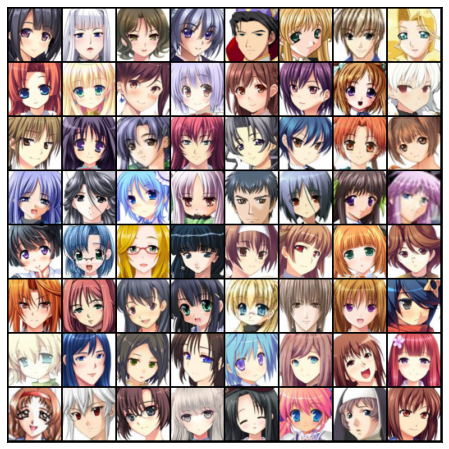

In [96]:
show_batch(train_dl)

# Using a GPU

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU, if one is available.

In [97]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [98]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [99]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [100]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [101]:
discriminator = to_device(discriminator, device)

# Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which performs to as a *transposed convolution* or *deconvolution*.

In [102]:
latent_size = 128

In [103]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True), #the value 'True' is to perform the ReLU inplace
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True), 
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 128, 1, 1])
torch.Size([128, 3, 64, 64])


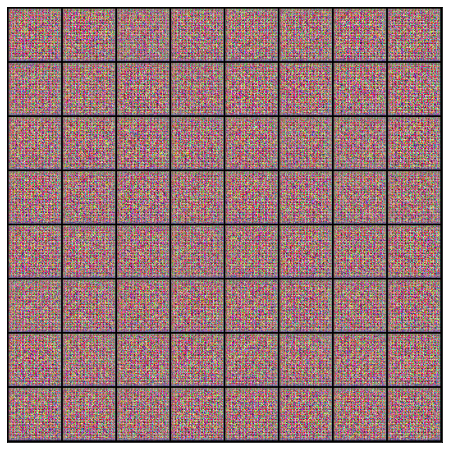

In [104]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet.

In [105]:
generator = to_device(generator, device)

# Discriminator and Generator training Funcs

## Discriminator Training

In [106]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds   = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss    = F.binary_cross_entropy(real_preds, real_targets)
    real_score   = torch.mean(real_preds).item()
    
    # Generate fake images
    latent       = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images  = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds   = discriminator(fake_images)
    fake_loss    = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score   = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- We then pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- We add the two losses and use the overall loss to perform gradient descent to adjust the discriminator weights.

Note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

## Generator Training

- We generate a batch of images using the generator, pass the into the discriminator. We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to ***fool*** the discriminator.

The code for this is below:

In [107]:
def train_generator(opt_g):
    opt_g.zero_grad() # clear the generator gradients
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [108]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [109]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = f"generated-images-{index:04d}.png"
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [110]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


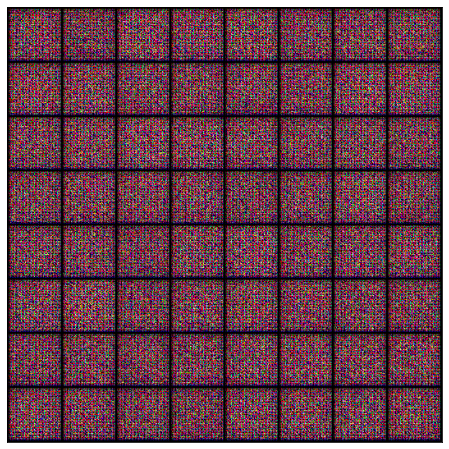

In [111]:
save_samples(0, fixed_latent)

# Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.



In [112]:
def fit(epochs, lr, start_idx=1):

    torch.cuda.empty_cache() #empty gpu cache
    # Losses & scores
    losses_g, losses_d, real_scores, fake_scores = [],[],[],[]
    
    # Create optimizers; opt_d & opt_g are for the discriminator and generator
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters()    , lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f},\n\
        real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [113]:
lr     = 3e-4  # learning rate
epochs = 25    # no. of epochs

In [114]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 7.3369, loss_d: 1.5794,
        real_score: 0.9436, fake_score: 0.7337
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.0320, loss_d: 0.2423,
        real_score: 0.8574, fake_score: 0.0696
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.4309, loss_d: 0.3599,
        real_score: 0.8946, fake_score: 0.1938
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.1424, loss_d: 0.1727,
        real_score: 0.9305, fake_score: 0.0644
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.7026, loss_d: 0.1299,
        real_score: 0.9074, fake_score: 0.0201
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.8444, loss_d: 0.1864,
        real_score: 0.9343, fake_score: 0.0709
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 9.9635, loss_d: 0.3571,
        real_score: 0.9400, fake_score: 0.2285
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.5237, loss_d: 0.0523,
        real_score: 0.9693, fake_score: 0.0171
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 7.0431, loss_d: 0.1258,
        real_score: 0.9592, fake_score: 0.0722
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 7.4131, loss_d: 0.1591,
        real_score: 0.9987, fake_score: 0.1144
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 6.0746, loss_d: 0.0886,
        real_score: 0.9612, fake_score: 0.0385
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 10.8084, loss_d: 0.0249,
        real_score: 0.9782, fake_score: 0.0012
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.6773, loss_d: 0.0558,
        real_score: 0.9784, fake_score: 0.0316
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.4294, loss_d: 0.1218,
        real_score: 0.9414, fake_score: 0.0276
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.8020, loss_d: 0.1891,
        real_score: 0.8951, fake_score: 0.0123
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 8.1670, loss_d: 0.0919,
        real_score: 0.9680, fake_score: 0.0545
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.6982, loss_d: 0.1793,
        real_score: 0.8911, fake_score: 0.0009
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.1474, loss_d: 0.0689,
        real_score: 0.9787, fake_score: 0.0300
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 11.1570, loss_d: 0.3394,
        real_score: 0.8044, fake_score: 0.0041
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 19.2157, loss_d: 0.3758,
        real_score: 0.9986, fake_score: 0.2452
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.6771, loss_d: 0.1014,
        real_score: 0.9920, fake_score: 0.0861
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 7.8651, loss_d: 0.0480,
        real_score: 0.9969, fake_score: 0.0420
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 6.7200, loss_d: 0.0709,
        real_score: 0.9792, fake_score: 0.0475
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 6.9102, loss_d: 0.0336,
        real_score: 0.9814, fake_score: 0.0134
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 15.3512, loss_d: 0.0226,
        real_score: 0.9989, fake_score: 0.0188
Saving generated-images-0025.png


In [115]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

Here's how the generated images look, after some of the epochs of training.

In [84]:
# image_nums = [i for i in range(25)]
# for i in image_nums[::5]:
#     Image(f"./generated/generated-images-{i:04d}.png")

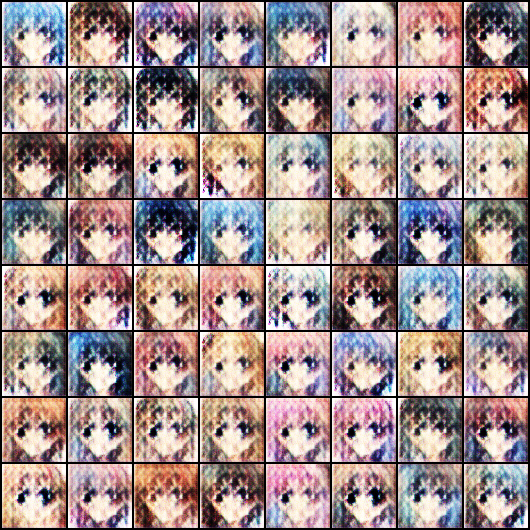

In [125]:
i = 1
Image(f"./generated/generated-images-{i:04d}.png")

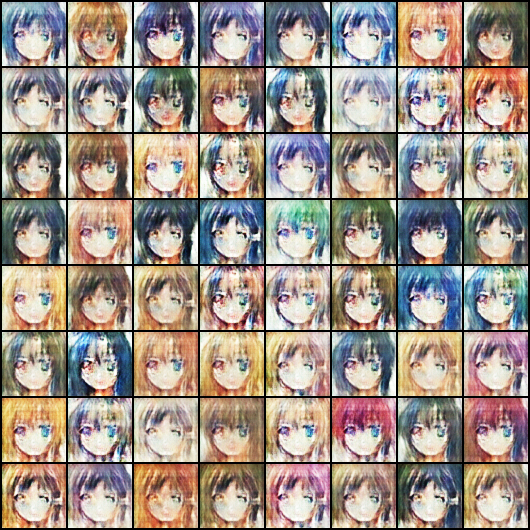

In [117]:
i = 10
Image(f"./generated/generated-images-{i:04d}.png")

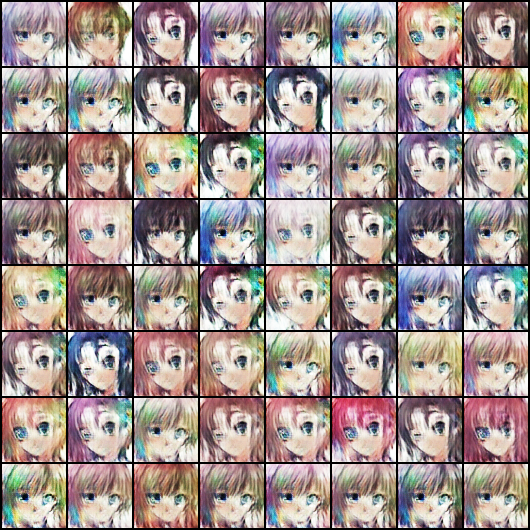

In [118]:
i = 15
Image(f"./generated/generated-images-{i:04d}.png")

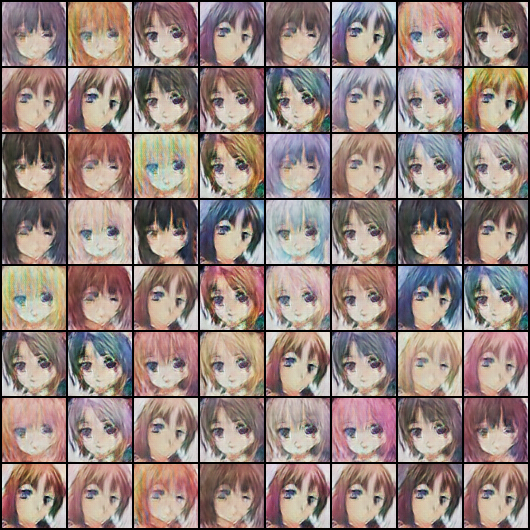

In [119]:
i = 25
Image(f"./generated/generated-images-{i:04d}.png")

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



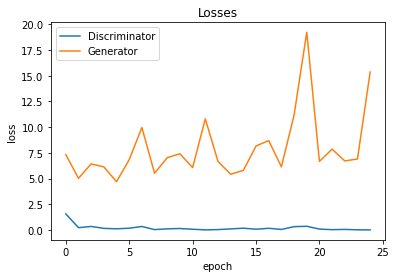

In [120]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

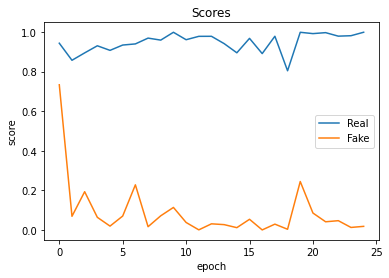

In [121]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

# Save the Model


In [122]:
# Save the model checkpoints 
torch.save(generator.state_dict()    , 'Gen_state.pth')
torch.save(discriminator.state_dict(), 'Dis_state.pth')

In [123]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()